# Functional Renormalization Group for Signal Detection

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import json
import matplotlib as mpl
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path
from typing import Any

from frg import MarchenkoPastur, EmpiricalDistribution
from frg.distributions.distributions import Distribution

plt.style.use("grayscale")

mpl.rc("font", size=16)

In [ ]:
output_dir = Path("../plots")
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
def compute_roi(
    data: dict[str, Any], thresh: float = 0.5
) -> tuple[int, int, int]:
    """
    Compute the indices of the region of interest, and its initial and final points.

    Parameters
    ----------
    data : dict[str, Any]
        The results of the computation of the canonical dimensions.
    thresh : float
        The value of the threshold on the distribution to be considered "bulk". By default `0.5`.

    Returns
    -------
    tuple[int, int, int]
        The point of interest, the start of the region of interest, the end of the region of interest
    """
    top = np.argmax(data["dist"])
    start = np.argmin(np.abs(np.array(data["dist"][:top]) - thresh))

    idx = start + (top - start) // 2

    return idx, start, top


In [ ]:
def interp_canonical_dimensions(
    data: dict[str, Any], idx: int
) -> tuple[Any, Any, Any]:
    """
    Interpolate the canonical dimensions.

    Parameters
    ----------
    data : dict[str, Any]
        The experimental data.
    idx : int
        The index of the starting point.
    """
    dimu2_interp = np.poly1d(
        np.polyfit(data["k2"][idx:], data["dimu2"][idx:], 1)
    )
    dimu4_interp = np.poly1d(
        np.polyfit(data["k2"][idx:], data["dimu4"][idx:], 1)
    )
    dimu6_interp = np.poly1d(
        np.polyfit(data["k2"][idx:], data["dimu6"][idx:], 1)
    )
    return dimu2_interp, dimu4_interp, dimu6_interp

In [ ]:
def extract_interp_values(
    data: dict[str, Any], thresh: float = 0.5, deep_ir: bool = False
) -> tuple[float, float, float, float]:
    """
    Extract the interpolated values.

    Parameters
    ----------
    data : dict[str, Any]
        The experimental data.
    thresh : float
        The value of the threshold on the distribution to be considered "bulk". By default `0.5`.
    deep_ir : bool
        Return the values of the interpolation at the deep IR scale. By default `False`.

    Returns
    -------
    tuple[float, float, float, float]
        The values of :math:`k^2`, :math:`\\text{dim}(u_{2})`, :math:`\\text{dim}(u_{4})`, and :math:`\\text{dim}(u_{6})` at the reference scale.
    """
    idx, _, _ = compute_roi(data, thresh)
    dimu2_interp, dimu4_interp, dimu6_interp = interp_canonical_dimensions(
        data, idx
    )

    k2 = float(data["k2"][idx]) if not deep_ir else 0.0
    return (
        k2,
        float(dimu2_interp(k2)),
        float(dimu4_interp(k2)),
        float(dimu6_interp(k2)),
    )

In [ ]:
def plot_canonical_dimensions(
    data: dict[str, Any],
    thresh: float = 0.5,
    suffix: str | None = None,
    analytic: bool = False,
):
    """
    Plot a single instance of the canonical dimensions.

    Parameters
    ----------
    data : dict[str, Any]
        The results of the computation of the canonical dimensions.
    thresh : float
        The value of the threshold on the distribution to be considered "bulk". By default `0.5`.
    suffix : str, optional
        The suffix of the file name.
    analytic : bool
        Analytic computation. By default `False`.
    """
    _, ax = plt.subplots(figsize=(7, 5), layout="constrained")

    # Compute the point between the max and the start
    idx, start, top = compute_roi(data=data, thresh=thresh)

    ax.plot(
        data["k2"],
        data["dimu2"],
        "r-",
        alpha=0.25 if not analytic else 1.0,
        label=None if not analytic else r"$\text{dim}(u_{2})$",
    )
    ax.plot(
        data["k2"],
        data["dimu4"],
        "g--",
        alpha=0.25 if not analytic else 1.0,
        label=None if not analytic else r"$\text{dim}(u_{4})$",
    )
    ax.plot(
        data["k2"],
        data["dimu6"],
        "b-.",
        alpha=0.25 if not analytic else 1.0,
        label=None if not analytic else r"$\text{dim}(u_{6})$",
    )

    # Interpolations
    if not analytic:
        dimu2_interp, dimu4_interp, dimu6_interp = interp_canonical_dimensions(
            data, idx
        )

        ax.plot(
            data["k2"],
            dimu2_interp(data["k2"]),
            "r-",
            label=r"$\text{dim}(u_{2})$",
        )
        ax.plot(
            data["k2"],
            dimu4_interp(data["k2"]),
            "g--",
            label=r"$\text{dim}(u_{4})$",
        )
        ax.plot(
            data["k2"],
            dimu6_interp(data["k2"]),
            "b-.",
            label=r"$\text{dim}(u_{6})$",
        )

        ax.axvspan(
            data["k2"][start],
            data["k2"][top],
            ls="dashed",
            color="r",
            alpha=0.05,
        )
        ax.axvline(data["k2"][idx], ls="dashed", color="r", alpha=0.25)

    ax.set_xlabel(r"$k^2$")
    ax.set_ylabel("canonical dimensions")
    ax.ticklabel_format(
        axis="both", style="sci", scilimits=(0, 0), useMathText=True
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=False,
    )
    ax2 = ax.twinx()
    ax2.plot(data["k2"], data["dist"], "k--")
    ax2.set(ylabel="PDF")

    if suffix is None:
        plt.savefig(output_dir / "canonical_dimensions.pdf")
    else:
        plt.savefig(output_dir / f"canonical_dimensions_{suffix}.pdf")

In [ ]:
def add_values(
    interp_values: tuple[float, float, float, float],
    scale: list[float],
    dimu2: list[float],
    dimu4: list[float],
    dimu6: list[float],
):
    """
    Add values to lists.

    Parameters
    ----------
    interp_values : tuple[float, float, float, float]
        The interpolated values of :math:`k^2`, :math:`\\text{dim}(u_{2})`, :math:`\\text{dim}(u_{4})`, :math:`\\text{dim}(u_{6})`.
    scale : list[float]
        The list of values of the reference scale :math:`k^2`.
    dimu2 : list[float]
        The list of values of :math:`\\text{dim}(u_{2})`.
    dimu4 : list[float]
        The list of values of :math:`\\text{dim}(u_{4})`.
    dimu6 : list[float]
        The list of values of :math:`\\text{dim}(u_{6})`.
    """
    k2, dimu2_value, dimu4_value, u6 = interp_values
    scale.append(k2)
    dimu2.append(dimu2_value)
    dimu4.append(dimu4_value)
    dimu6.append(u6)


In [ ]:
def plot_canonical_dimensions_scan(
    x: list[float],
    name: str,
    dimu2: list[float] | None = None,
    dimu4: list[float] | None = None,
    dimu6: list[float] | None = None,
):
    """
    Plot the canonical dimensions as a function of a particular quantity of interest.

    Parameters
    ----------
    x : list[float]
        The quantity of interest.
    name : str
        The label of the x-axis.
    dimu2 : list[float], optional
        The list of values of the canonical dimension of the quadratic coupling.
    dimu4 : list[float], optional
        The list of values of the canonical dimension of the quartic coupling.
    dimu6 : list[float], optional
        The list of values of the canonical dimension of the sextic coupling.
    """
    _, ax = plt.subplots(figsize=(7, 5), layout="constrained")

    if dimu2 is not None:
        ax.plot(x, dimu2, "rx", label=r"$\text{dim}(u_{2})$")
        ax.plot(x, dimu2, "r-", alpha=0.25)
    if dimu4 is not None:
        ax.plot(x, dimu4, "gx", label=r"$\text{dim}(u_{4})$")
        ax.plot(x, dimu4, "g--", alpha=0.25)
    if dimu6 is not None:
        ax.plot(x, dimu6, "bx", label=r"$\text{dim}(u_{6})$")
        ax.plot(x, dimu6, "b-.", alpha=0.25)

    ax.set(xlabel=name, ylabel=r"$\text{dim}$")
    ax.ticklabel_format(
        axis="both", style="sci", scilimits=(0, 0), useMathText=True
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=False,
    )

In [ ]:
def plot_distribution(dist: Distribution):
    """
    Plot distributions.

    Parameters
    ----------
    dist : Distribution
        The distribution to show.
    """
    _, ax = plt.subplots(ncols=2, figsize=(14, 5), layout="constrained")

    # Show axes
    ax[0].axhline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[0].axvline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[0].set(xlabel="$\\lambda$", ylabel="$\\mu$")
    ax[1].axhline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[1].axvline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[1].set(xlabel="$k^2$", ylabel="$\\rho$")

    if isinstance(dist, MarchenkoPastur):
        # PDF
        x = np.linspace(0.0, 1.05 * dist.lplus, num=1000)
        y = dist.pdf(x)
        ax[0].plot(x, y, "k-")

        # PDF of the inverse
        x = np.linspace(0.0, 3.0, num=1000)
        y = dist.ipdf(x)
        ax[1].plot(x, y, "k-")

        plt.savefig(
            output_dir
            / f"marchenkopastur_ratio={dist.ratio}_sigma={dist.sigma}.pdf"
        )

    else:
        evls = dist.eigenvalues_

        # PDF
        ax[0].hist(
            evls,
            bins=2 * int(np.sqrt(len(evls))),
            color="b",
            alpha=0.5,
            density=True,
        )

        x = np.linspace(0.0, 1.05 * dist.lplus, num=1000)
        y = dist.pdf(x)
        ax[0].plot(x, y, "k-")

        # PDF of the inverse
        x = np.linspace(0.0, 3.0, num=1000)
        y = dist.ipdf(x)
        ax[1].plot(x, y, "k-")

        plt.savefig(
            output_dir
            / f"empirical_ratio={dist.ratio}_sigma={dist.sigma}_nsamples={dist.n_samples}.pdf"
        )

## Marchenko-Pastur Distribution

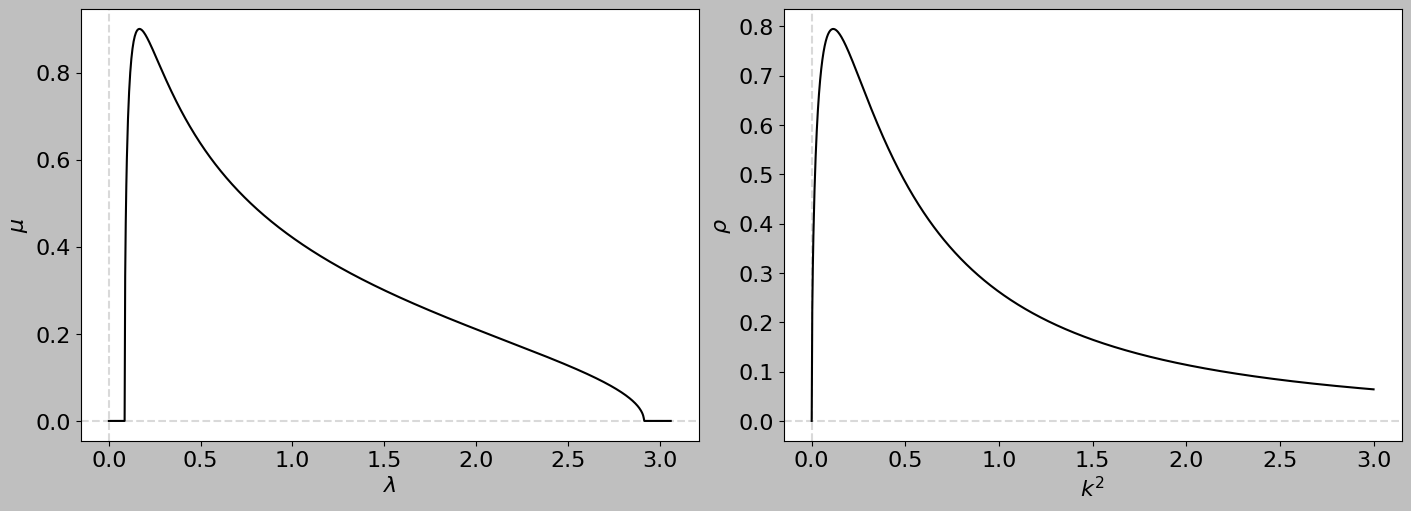

In [ ]:
mp = MarchenkoPastur(ratio=0.5, sigma=1.0)
plot_distribution(mp)

In [ ]:
emp = EmpiricalDistribution(n_samples=1000, sigma=1.0, ratio=0.85)
emp = emp.fit()

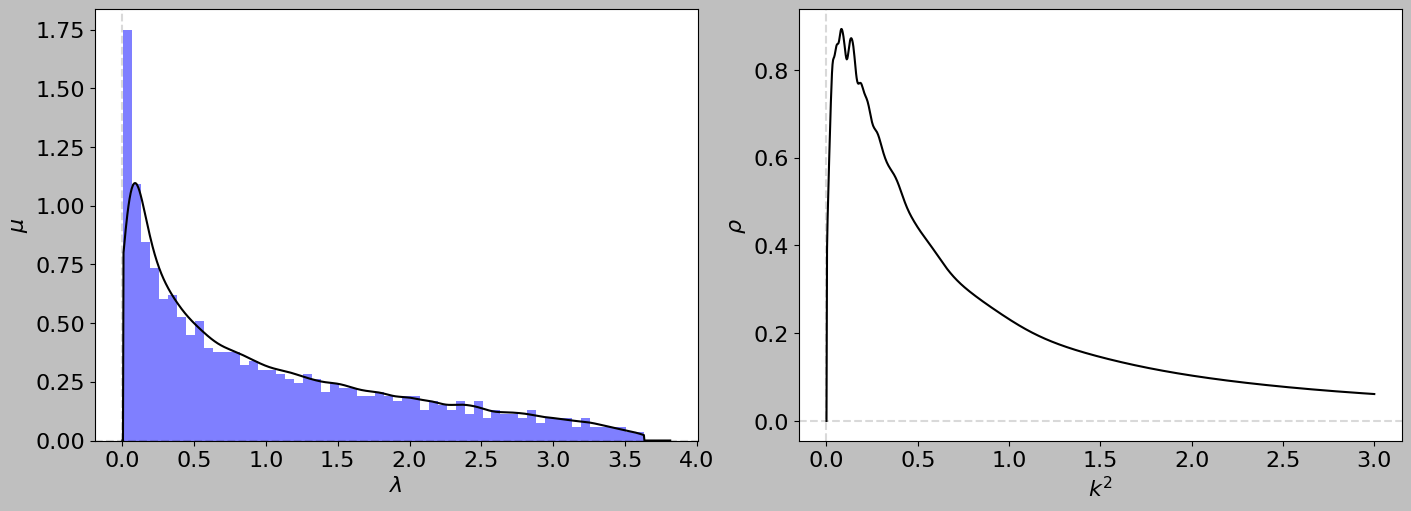

In [ ]:
plot_distribution(emp)

In [ ]:
snr, dimu2, dimu4, dimu6 = [], [], [], []
scale = []

In [ ]:
!../scripts/canonical_dimensions.py --help

usage: canonical_dimensions.py [-h] [--config CONFIG] [--analytic]
                               [--print_config]
                               [--suffix {snr,var,ratio,seed}]
                               [--args ARGS [ARGS ...]] [-v]

Compute the canonical dimensions of the couplings in a theory with given
momenta distribution.

options:
  -h, --help            show this help message and exit
  --config CONFIG       Configuration file
  --analytic            Run an analytic simulation
  --print_config        Print configuration
  --suffix {snr,var,ratio,seed}
                        Type of suffix used in the output files
  --args ARGS [ARGS ...]
                        Additional configuration arguments (see YACS
                        documentation)
  -v                    Verbosity level

For bug reports and info: Riccardo Finotello <riccardo.finotello@cea.fr>


In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --args SIG.SNR 0.0

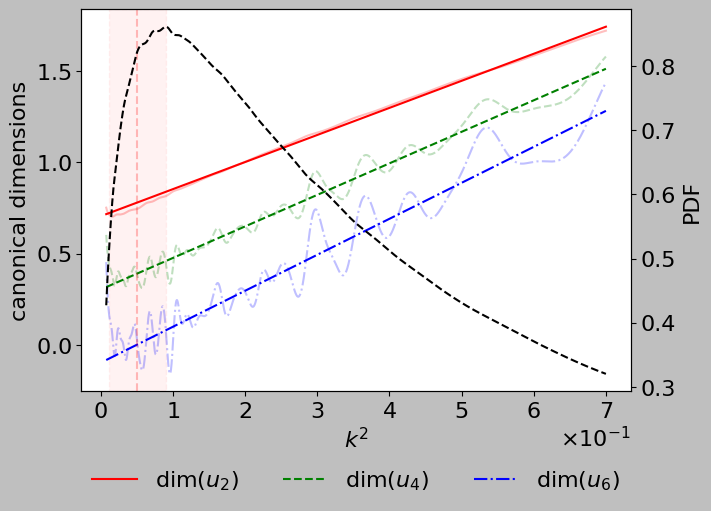

In [ ]:
data = "results/mp_canonical_dimensions_snr=0.0.json"
with open(data) as f:
    data = json.load(f)

add_values(extract_interp_values(data), scale, dimu2, dimu4, dimu6)
snr.append(0.0)

plot_canonical_dimensions(data, suffix="snr=0.0")

In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --args SIG.SNR 0.45

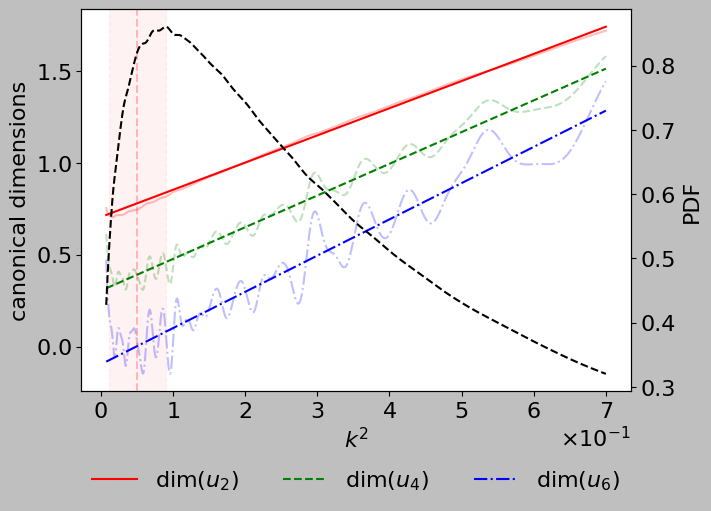

In [ ]:
data = "results/mp_canonical_dimensions_snr=0.45.json"
with open(data) as f:
    data = json.load(f)

add_values(extract_interp_values(data), scale, dimu2, dimu4, dimu6)
snr.append(0.45)

plot_canonical_dimensions(data, suffix="snr=0.45")

In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --args SIG.SNR 0.90

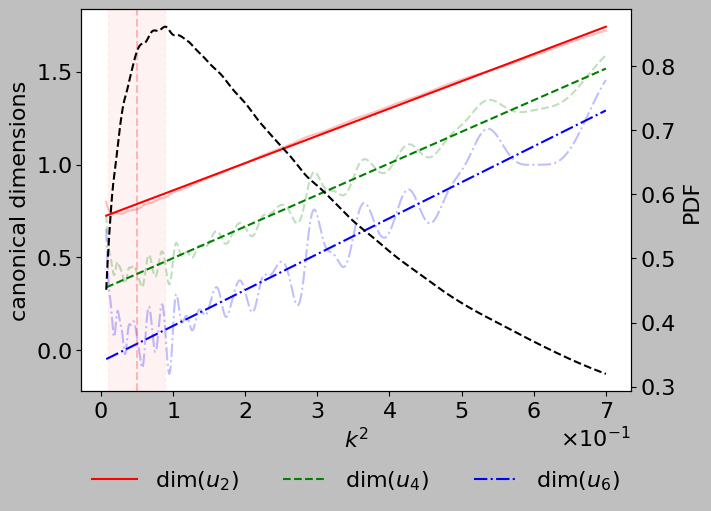

In [ ]:
data = "results/mp_canonical_dimensions_snr=0.9.json"
with open(data) as f:
    data = json.load(f)

add_values(extract_interp_values(data), scale, dimu2, dimu4, dimu6)
snr.append(0.90)

plot_canonical_dimensions(data, suffix="snr=0.90")

In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --args SIG.SNR 1.25

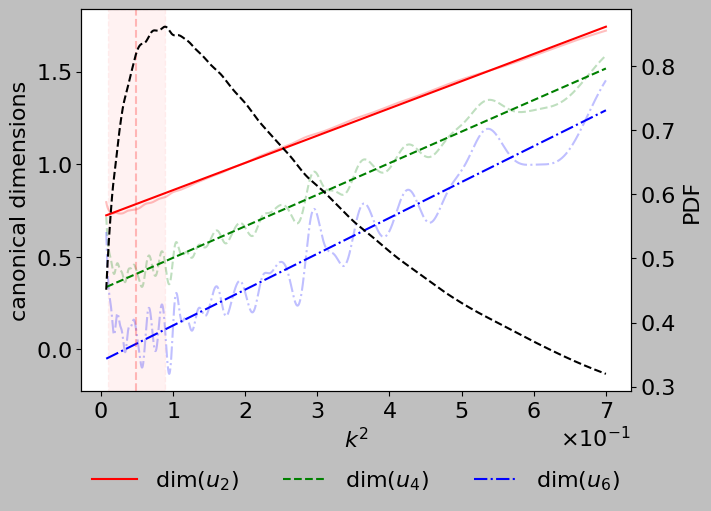

In [ ]:
data = "results/mp_canonical_dimensions_snr=1.25.json"
with open(data) as f:
    data = json.load(f)

add_values(extract_interp_values(data), scale, dimu2, dimu4, dimu6)
snr.append(1.25)

plot_canonical_dimensions(data, suffix="snr=1.25")

In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --args SIG.SNR 2.25

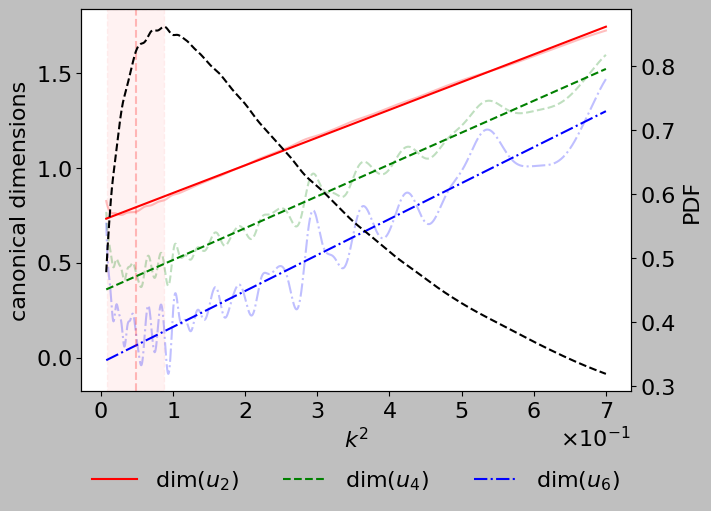

In [ ]:
data = "results/mp_canonical_dimensions_snr=2.25.json"
with open(data) as f:
    data = json.load(f)

add_values(extract_interp_values(data), scale, dimu2, dimu4, dimu6)
snr.append(2.25)

plot_canonical_dimensions(data, suffix="snr=2.25")

In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --args SIG.SNR 3.0

^C


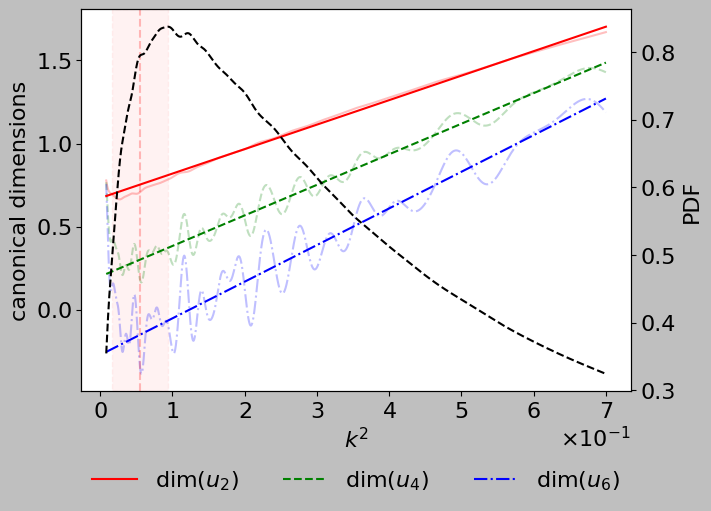

In [ ]:
data = "results/mp_canonical_dimensions_snr=3.0.json"
with open(data) as f:
    data = json.load(f)

add_values(extract_interp_values(data), scale, dimu2, dimu4, dimu6)
snr.append(3.0)

plot_canonical_dimensions(data, suffix="snr=3.0")

In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --args SIG.SNR 4.0

Traceback (most recent call last):
  File "/home/catA/rf265700/Code/frg-signal-detection/notebooks/../scripts/canonical_dimensions.py", line 124, in <module>
    code = main(args)
           │    └ Namespace(config='../configs/config_canonical_dimensions.yaml', analytic=False, print_config=False, suffix='snr', args=['SIG.SNR...
           └ <function main at 0x7975ec9da340>
  File "/home/catA/rf265700/Code/frg-signal-detection/notebooks/../scripts/canonical_dimensions.py", line 60, in main
    dist = load_data(cfg)
           │         └ CfgNode({'DIST': CfgNode({'NUM_SAMPLES': 20000, 'SIGMA': 1.0, 'RATIO': 0.9, 'SEED': 42}), 'SIG': CfgNode({'INPUT': '$SCRATCHDIR/...
           └ <function load_data at 0x7975818a8540>
  File "/home/catA/rf265700/Code/frg-signal-detection/src/frg/utils/utils.py", line 110, in load_data
    raise FileNotFoundError("Input data file %s does not exist!" % data)
                                                                   └ PosixPath('/home/catA/rf2657

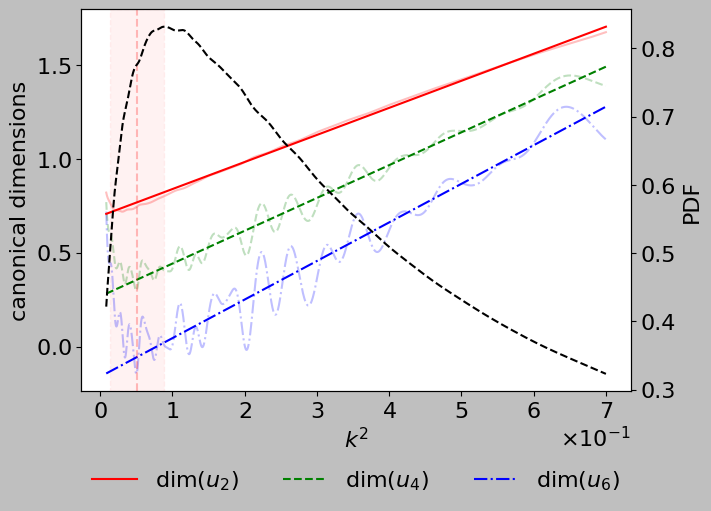

In [ ]:
data = "results/mp_canonical_dimensions_snr=4.0.json"
with open(data) as f:
    data = json.load(f)

add_values(extract_interp_values(data), scale, dimu2, dimu4, dimu6)
snr.append(4.0)

plot_canonical_dimensions(data, suffix="snr=4.0")

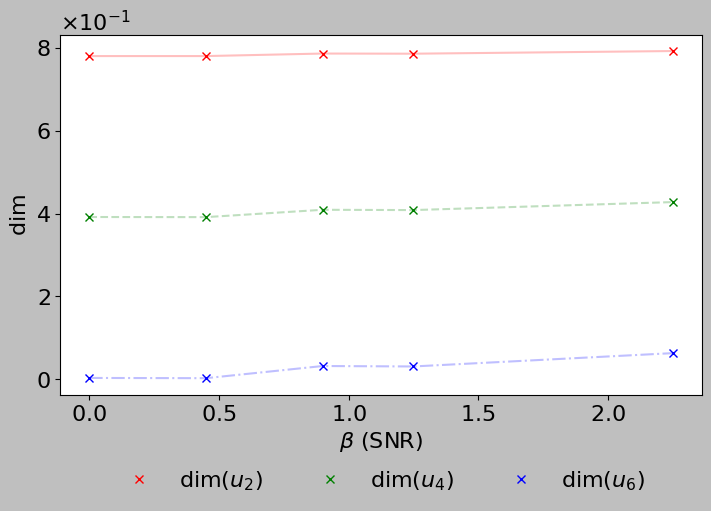

In [ ]:
plot_canonical_dimensions_scan(snr, r"$\beta$ (SNR)", dimu2, dimu4, dimu6)

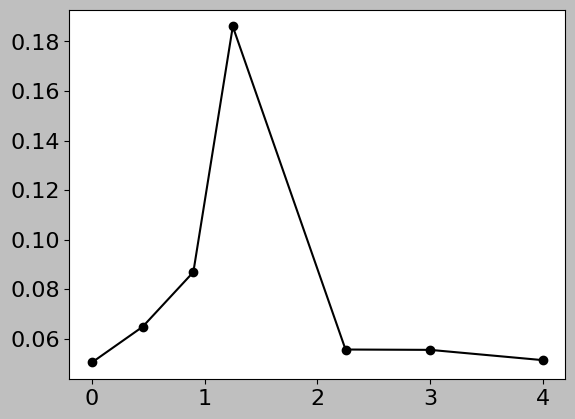

In [ ]:
plt.plot(snr, scale, "ko-")

In [ ]:
!../scripts/canonical_dimensions.py --config ../configs/config_canonical_dimensions.yaml --analytic

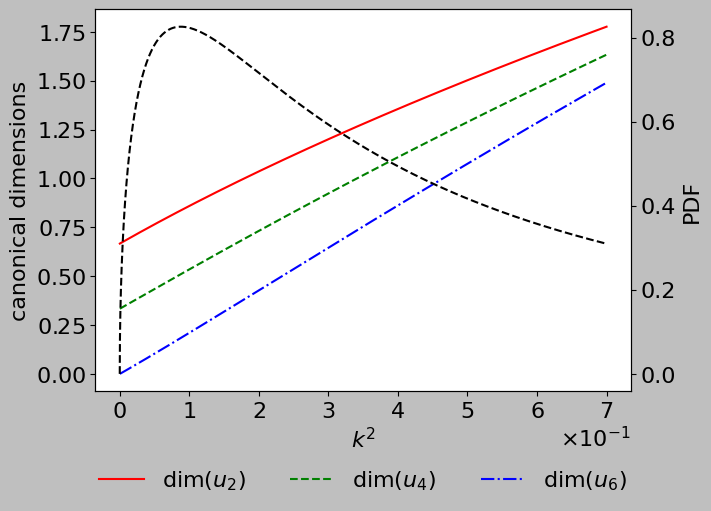

In [ ]:
data = "results/mp_canonical_dimensions_analytic.json"
with open(data) as f:
    data = json.load(f)

plot_canonical_dimensions(data, suffix="analytic", analytic=True)